# Decoding Classical LDPC Codes

In this experiment, we decode a classical linear error correcting code -- Low Density Parity Check (LDPC) code.
First, we build a Matrix Product State containing the superposition of all codewords of a code instance.
Then, we demostrate simple decoding of a classical LDPC code using Dephasing DMRG --
our own built-in DMRG-like optimisation algorithm to solve the main component problem --
the problem of finding a computational basis state cotributing the most to a given state.

In [1]:
import numpy as np
import matplotlib
from tqdm import tqdm
import qecstruct as qec
from scipy.stats import sem
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.ticker import FormatStrFormatter
from mdopt.optimiser.utils import (
    ConstraintString,
    IDENTITY,
    SWAP,
    XOR_BULK,
    XOR_LEFT,
    XOR_RIGHT,
)
from examples.decoding.decoding import (
    linear_code_parity_matrix_dense,
    linear_code_constraint_sites,
    linear_code_prepare_message,
    linear_code_codewords,
    linear_code_checks,
)
from examples.decoding.decoding import (
    apply_bitflip_bias,
    apply_constraints,
    decode_message,
)
from mdopt.mps.utils import (
    create_simple_product_state,
    create_custom_product_state,
)
from mdopt.utils.utils import mpo_to_matrix

Let us first fix a random seed.

In [2]:
SEED = 123

Now we're going to define the parameters of a classical LDPC code. Since our first experiment will be getting out all of the codewords, we start with a small code so that we can do a dense-form simulation to check against the MPS-MPO evolution simulation.

In [3]:
NUM_BITS, NUM_CHECKS = 12, 9
CHECK_DEGREE, BIT_DEGREE = 4, 3
if NUM_BITS / NUM_CHECKS != CHECK_DEGREE / BIT_DEGREE:
    raise ValueError("The Tanner graph of the code must be bipartite.")

Now, let us construct the code object from ``qecstruct`` and prepare the initial MPS state as well as its dense-form vis-à-vis.

In [4]:
example_code = qec.random_regular_code(
    NUM_BITS, NUM_CHECKS, BIT_DEGREE, CHECK_DEGREE, qec.Rng(SEED)
)

state = create_simple_product_state(NUM_BITS, which="+")
state_dense = state.dense(flatten=True)

Here, we translate the error correcting code to the MPS-MPO language. This means we get the sites where the parity checks will be applied. We will construct MPOs using this data. These lists mention not only the sites where we will apply the XOR constraints but also other tensors, such as SWAPs (a.k.a. tensors' legs' crossings) as well as the boundary XOR constraints. In what follows we define the list of these auxiliary tensors and the corresponding sites where they should reside.

In [5]:
code_constraint_sites = linear_code_constraint_sites(example_code)
tensors = [XOR_LEFT, XOR_BULK, SWAP, XOR_RIGHT]
code_constraint_sites

[[[0], [6, 10], [1, 2, 3, 4, 5, 7, 8, 9], [11]],
 [[2], [4, 8], [3, 5, 6, 7, 9], [10]],
 [[1], [6, 9], [2, 3, 4, 5, 7, 8], [10]],
 [[0], [4, 7], [1, 2, 3, 5, 6], [8]],
 [[2], [4, 6], [3, 5], [7]],
 [[3], [5, 7], [4, 6], [8]],
 [[0], [2, 3], [1, 4, 5, 6, 7, 8], [9]],
 [[1], [5, 9], [2, 3, 4, 6, 7, 8, 10], [11]],
 [[1], [3, 5], [2, 4, 6, 7, 8, 9, 10], [11]]]

So, we are ready to check the codewords! We will do this by explicitly constructing the MPS containing equal superposition of all codewords, densifying it and finally checking all the non-zero elements. This MPS will be prepared by applying constraint MPOs to a all-plus state while renormalising it after each contraction so that the norm isn't being lost. We start with the MPS-MPO contraction:

In [6]:
state = apply_constraints(
    state,
    code_constraint_sites,
    tensors,
    renormalise=True,
    result_to_explicit=False,
    silent=False,
    strategy="Naive",
)

100%|██████████| 9/9 [00:00<00:00, 237.89it/s]


and continue by the dense-form simulation.

In [7]:
# Preparing the codeword superposition state in the dense form.
for j in tqdm(range(NUM_CHECKS)):
    # Preparing the MPO.
    constraint_string = ConstraintString(tensors, code_constraint_sites[j])
    constraint_mpo = constraint_string.mpo()

    # Finding the starting site of the MPS to build a correct dense-form operator.
    START_SITE = min(constraint_string.flat())

    # Preparing the dense-form operator.
    identities_l = [IDENTITY for _ in range(START_SITE)]
    identities_r = [
        IDENTITY for _ in range(NUM_BITS - len(constraint_mpo) - START_SITE)
    ]
    full_mpo = identities_l + constraint_mpo + identities_r
    mpo_dense = mpo_to_matrix(full_mpo, interlace=False, group=True)

    # Doing the contraction in dense form.
    state_dense = mpo_dense @ state_dense

100%|██████████| 9/9 [00:01<00:00,  6.26it/s]


Now we are ready to check that the two objects represent the same thing.

In [8]:
# Tolerance under which we round tensor elements to zero.
TOL = 1e-12
mps_dense = state.dense(flatten=True)
mps_dense[np.abs(mps_dense) < TOL] = 0

# Retreiving codewords.
cwords = linear_code_codewords(example_code)
cwords_to_compare_mps = np.flatnonzero(mps_dense)
cwords_to_compare_dense = np.flatnonzero(state_dense)

print()
print("Codewords from the generator matrix:")
print(cwords)
print("Codewords from the dense-form simulation:")
print(cwords_to_compare_mps)
print("Codewords from the MPS-form simulation:")
print(cwords_to_compare_dense)
print("")
print(
    "All lists of codewords match:",
    np.logical_and(
        np.array_equal(cwords, cwords_to_compare_mps),
        np.array_equal(cwords_to_compare_mps, cwords_to_compare_dense),
    ),
)


Codewords from the generator matrix:
[   0   58  407  429 3666 3688 4037 4095]
Codewords from the dense-form simulation:
[   0   58  407  429 3666 3688 4037 4095]
Codewords from the MPS-form simulation:
[   0   58  407  429 3666 3688 4037 4095]

All lists of codewords match: True


Now that we have checked that we are able to prepare the codeword state, let's try and do the decoding. The setup is as follows: we receive a message (which might contain errors) and need to find what was the initial message. In order to do this, we first apply a bitflip bias to our MPS, which biases the state towards the received message by redistributing the amplitudes according to the Hamming distance from the message. Then, we apply the parity checks and solve the main component problem. Let's see how this works in practice. Note, that the final overlap quantity received from the algorithm can be either $0$ or $1$ (the anticipated outcome) because in the end we need a basis product state.

In [9]:
print("")
print("Retreiving a perturbed codeword:")
print("")

# Defining the parameters of a classical LDPC code.
NUM_BITS, NUM_CHECKS = 20, 15
CHECK_DEGREE, BIT_DEGREE = 4, 3
if NUM_BITS / NUM_CHECKS != CHECK_DEGREE / BIT_DEGREE:
    raise ValueError("The Tanner graph of the code must be bipartite.")

# Defining the bias channel parameter and the error rate.
ERROR_RATE = 0.15
PROB_BIAS = ERROR_RATE

# Maximum bond dimension and spectra cut for contractor/DMRG.
CHI_MAX_CONTRACTOR = 1e4
CHI_MAX_DMRG = 1e4
CUT = 1e-12
# Number of DMRG sweeps.
NUM_DMRG_RUNS = 1

# Constructing the code as a qecstruct object.
example_code = qec.random_regular_code(
    NUM_BITS, NUM_CHECKS, BIT_DEGREE, CHECK_DEGREE, qec.Rng(SEED)
)

# Getting the sites where each string of constraints should be applied.
code_constraint_sites = linear_code_constraint_sites(example_code)

# Building an initial and a perturbed codeword.
INITIAL_CODEWORD, PERTURBED_CODEWORD = linear_code_prepare_message(
    example_code, ERROR_RATE, error_model=qec.BinarySymmetricChannel, seed=SEED
)
print("The initial codeword is  ", INITIAL_CODEWORD)
print("The perturbed codeword is", PERTURBED_CODEWORD)
print("")

# Building the corresponding matrix product states.
initial_codeword_state = create_custom_product_state(
    INITIAL_CODEWORD, form="Right-canonical"
)
perturbed_codeword_state = create_custom_product_state(
    PERTURBED_CODEWORD, form="Right-canonical"
)

# Applying the bitflip bias to the perturbed codeword state.
perturbed_codeword_state = apply_bitflip_bias(
    mps=perturbed_codeword_state,
    sites_to_bias="All",
    prob_bias_list=PROB_BIAS,
    renormalise=True,
)

print("Applying constraints:")
print("")
# Applying the parity constraints defined by the code.
perturbed_codeword_state = apply_constraints(
    perturbed_codeword_state,
    code_constraint_sites,
    tensors,
    chi_max=CHI_MAX_CONTRACTOR,
    renormalise=True,
    result_to_explicit=False,
    strategy="Optimised",
    silent=False,
)

print("")
print("Decoding:")
print("")
# Decoding the perturbed codeword.
dmrg_container, success = decode_message(
    message=perturbed_codeword_state,
    codeword=initial_codeword_state,
    num_runs=NUM_DMRG_RUNS,
    chi_max_dmrg=CHI_MAX_DMRG,
    cut=CUT,
    silent=False,
)
print("")
print(
    "The overlap of the density MPO main component and the initial codeword state: ",
    success,
)


Retreiving a perturbed codeword:

The initial codeword is   00001011111000010001
The perturbed codeword is 00000011111010000100

Applying constraints:



100%|██████████| 15/15 [00:06<00:00,  2.31it/s]



Decoding:



100%|██████████| 1/1 [00:00<00:00,  5.28it/s]


The overlap of the density MPO main component and the initial codeword state:  1.0


Let us now take a look at how the bond dimensions and entropies behave throughout the decoding process while applying the parity checks.

In [10]:
NUM_BITS = 16
CHI_MAX_CONTRACTOR = 1e4
CHI_MAX_DMRG = CHI_MAX_CONTRACTOR
ERROR_RATE = 0.15
PROB_BIAS = ERROR_RATE
CUT = 1e-16
NUM_DMRG_RUNS = 1
NUM_EXPERIMENTS = 100

SEED = 123
seed_seq = np.random.SeedSequence(SEED)

CHECK_DEGREE, BIT_DEGREE = 4, 3
NUM_CHECKS = int(BIT_DEGREE * NUM_BITS / CHECK_DEGREE)
if NUM_BITS / NUM_CHECKS != CHECK_DEGREE / BIT_DEGREE:
    raise ValueError("The Tanner graph of the code must be bipartite.")

entropies = np.zeros((NUM_EXPERIMENTS, NUM_CHECKS, NUM_BITS - 1))
bond_dimensions = np.zeros((NUM_EXPERIMENTS, NUM_CHECKS, NUM_BITS - 1))

for l in tqdm(range(NUM_EXPERIMENTS)):
    new_seed = seed_seq.spawn(1)[0]
    rng = np.random.default_rng(new_seed)
    random_integer = rng.integers(1, 10**8 + 1)
    SEED = random_integer

    code = qec.random_regular_code(
        NUM_BITS, NUM_CHECKS, BIT_DEGREE, CHECK_DEGREE, qec.Rng(SEED)
    )
    code_constraint_sites = linear_code_constraint_sites(code)

    INITIAL_CODEWORD, PERTURBED_CODEWORD = linear_code_prepare_message(
        code, ERROR_RATE, error_model=qec.BinarySymmetricChannel, seed=SEED
    )
    tensors = [XOR_LEFT, XOR_BULK, SWAP, XOR_RIGHT]

    initial_codeword_state = create_custom_product_state(
        INITIAL_CODEWORD, form="Right-canonical"
    )
    perturbed_codeword_state = create_custom_product_state(
        PERTURBED_CODEWORD, form="Right-canonical"
    )

    perturbed_codeword_state = apply_bitflip_bias(
        mps=perturbed_codeword_state,
        sites_to_bias="All",
        prob_bias_list=PROB_BIAS,
        renormalise=True,
    )
    perturbed_codeword_state, entrs, bons = apply_constraints(
        perturbed_codeword_state,
        code_constraint_sites,
        tensors,
        chi_max=CHI_MAX_CONTRACTOR,
        renormalise=True,
        result_to_explicit=False,
        strategy="Naive",
        silent=True,
        return_entropies_and_bond_dims=True,
    )

    entropies[l] = np.array(entrs)
    bond_dimensions[l] = np.array(bons)

100%|██████████| 100/100 [00:29<00:00,  3.35it/s]


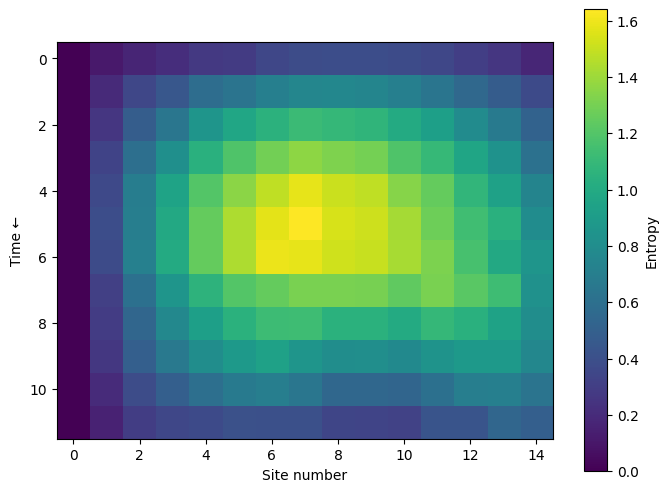

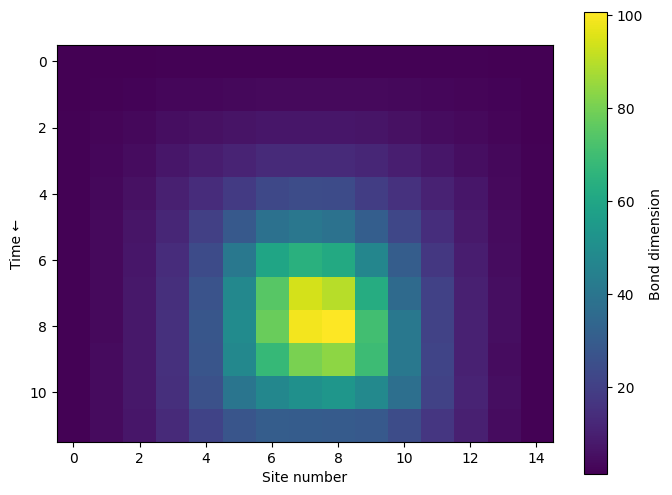

In [11]:
# Here we average over all the experiments and plot the results.

entropies = np.mean(entropies, axis=0)
bond_dimensions = np.mean(bond_dimensions, axis=0)

plt.figure(figsize=(8, 6))
plt.imshow(entropies, cmap="viridis")
plt.colorbar(label="Entropy")
plt.xlabel("Site number")
plt.ylabel("Time ←")
plt.show()

plt.figure(figsize=(8, 6))
plt.imshow(bond_dimensions, cmap="viridis")
plt.colorbar(label="Bond dimension")
plt.ylabel("Time ←")
plt.xlabel("Site number")
plt.show()

Nice, we do see how entanglement grows during the evolution and declines towards the end!

Let us now try to take a look at how the truncation affects the threshold for this family of codes. By definition, the threshold is the crossover error rate at which the code transitions from being unable to correct errors to being able to correct errors reliably. In simpler words, what we expect to see is how the logical error rate vs physical error rate curve will move up with more truncation. We will do this for a small 24-bit code for the sake of simplicity. Note, the following cell will take a while to run!

In [12]:
NUM_BITS = 24
NUM_EXPERIMENTS = 100

SEED = 123
seed_seq = np.random.SeedSequence(SEED)

max_bond_dims = [256, 128, 64, 32, 16, 8]
error_rates = np.linspace(0.1, 0.3, 11)
failures_statistics = {}

for CHI_MAX in max_bond_dims:
    for ERROR_RATE in tqdm(error_rates):
        failures = []

        for l in range(NUM_EXPERIMENTS):
            new_seed = seed_seq.spawn(1)[0]
            rng = np.random.default_rng(new_seed)
            random_integer = rng.integers(1, 10**8 + 1)
            SEED = random_integer

            CHECK_DEGREE, BIT_DEGREE = 4, 3
            NUM_CHECKS = int(BIT_DEGREE * NUM_BITS / CHECK_DEGREE)
            if NUM_BITS / NUM_CHECKS != CHECK_DEGREE / BIT_DEGREE:
                raise ValueError("The Tanner graph of the code must be bipartite.")
            PROB_BIAS = ERROR_RATE

            code = qec.random_regular_code(
                NUM_BITS, NUM_CHECKS, BIT_DEGREE, CHECK_DEGREE, qec.Rng(SEED)
            )
            code_constraint_sites = linear_code_constraint_sites(code)

            INITIAL_CODEWORD, PERTURBED_CODEWORD = linear_code_prepare_message(
                code, ERROR_RATE, error_model=qec.BinarySymmetricChannel, seed=SEED
            )
            tensors = [XOR_LEFT, XOR_BULK, SWAP, XOR_RIGHT]

            initial_codeword_state = create_custom_product_state(
                INITIAL_CODEWORD, form="Right-canonical"
            )
            perturbed_codeword_state = create_custom_product_state(
                PERTURBED_CODEWORD, form="Right-canonical"
            )

            perturbed_codeword_state = apply_bitflip_bias(
                mps=perturbed_codeword_state,
                sites_to_bias="All",
                prob_bias_list=PROB_BIAS,
                renormalise=True,
            )

            perturbed_codeword_state = apply_constraints(
                perturbed_codeword_state,
                code_constraint_sites,
                tensors,
                chi_max=CHI_MAX,
                renormalise=True,
                result_to_explicit=False,
                strategy="Optimised",
                silent=True,
            )

            dmrg_container, success = decode_message(
                message=perturbed_codeword_state,
                codeword=initial_codeword_state,
                num_runs=1,
                chi_max_dmrg=CHI_MAX,
                silent=True,
            )
            failures.append(1 - success)

        failures_statistics[NUM_BITS, CHI_MAX, ERROR_RATE] = failures

100%|██████████| 11/11 [02:40<00:00, 14.59s/it]


In [13]:
failure_rates = {}
error_bars = {}

for CHI_MAX in max_bond_dims:
    for ERROR_RATE in error_rates:
        failure_rates[NUM_BITS, CHI_MAX, ERROR_RATE] = np.mean(
            failures_statistics[NUM_BITS, CHI_MAX, ERROR_RATE]
        )
        error_bars[NUM_BITS, CHI_MAX, ERROR_RATE] = sem(
            failures_statistics[NUM_BITS, CHI_MAX, ERROR_RATE]
        )

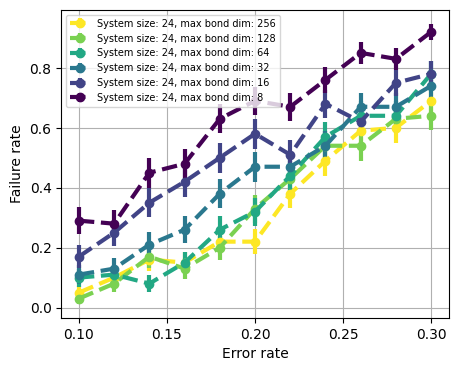

In [14]:
plt.figure(figsize=(5, 4))

green_cmap = matplotlib.colormaps["viridis_r"]
norm = Normalize(vmin=0, vmax=len(max_bond_dims) - 1)

for index, CHI_MAX in enumerate(max_bond_dims):
    plt.errorbar(
        error_rates,
        [failure_rates[NUM_BITS, CHI_MAX, ERROR_RATE] for ERROR_RATE in error_rates],
        yerr=[error_bars[NUM_BITS, CHI_MAX, ERROR_RATE] for ERROR_RATE in error_rates],
        fmt="o--",
        label=f"System size: {NUM_BITS}, max bond dim: {CHI_MAX}",
        linewidth=3,
        color=green_cmap(norm(index)),
    )

plt.xticks(np.arange(0.1, 0.35, 0.05), [f"{x:.2f}" for x in np.arange(0.1, 0.35, 0.05)])
plt.legend(fontsize=7)
plt.xlabel("Error rate")
plt.ylabel("Failure rate")
plt.grid()

plt.show()

We see what we expect: the decoder is able to correct more errors with less truncation. This is a good sign that the decoder is working as expected.